In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
sns.set_theme(style="whitegrid")

In [46]:
iris = pd.read_csv("IRIS.csv")

### Exploratory Data Analysis

In [47]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
# Type conversion
for column in iris.select_dtypes(include=["object"]).columns:
    iris[column].astype("category")

In [48]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [49]:
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [50]:
# Know the proportions of the feature class
iris["species"].value_counts(normalize=True)

species
Iris-setosa        0.333333
Iris-versicolor    0.333333
Iris-virginica     0.333333
Name: proportion, dtype: float64

##### It is a very balanced dataset

In [51]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


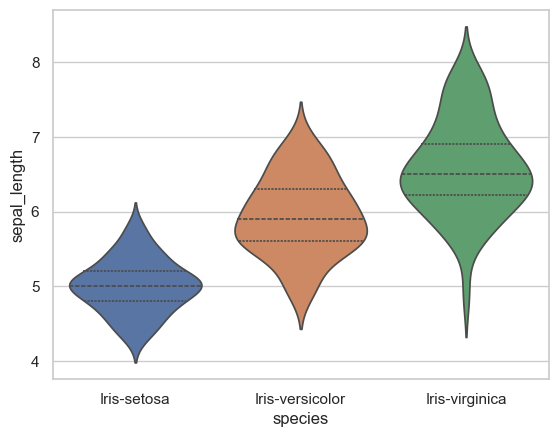

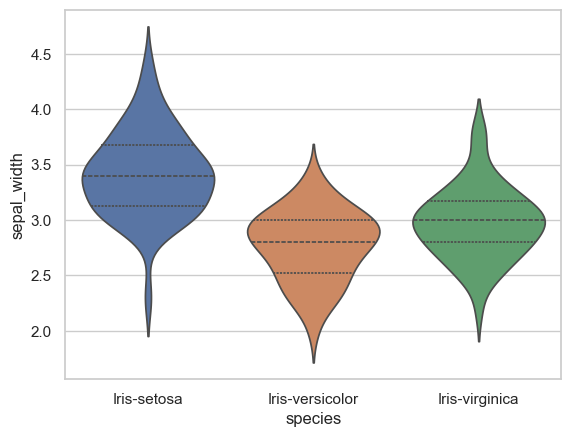

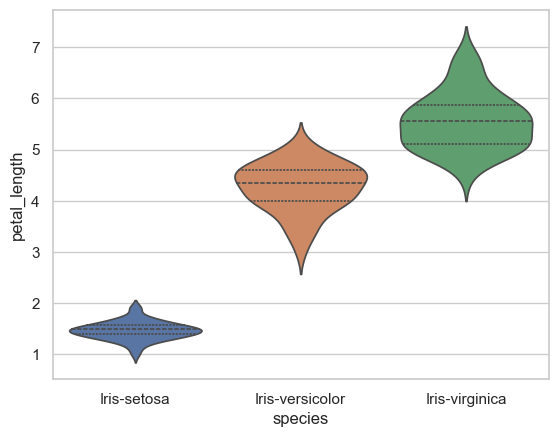

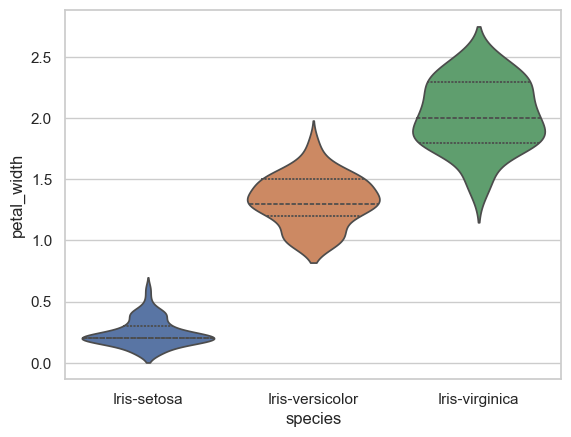

In [52]:
for column in iris.drop(columns=["species"], axis=1, inplace=False).columns:
    sns.violinplot(x=iris["species"], y=iris[column], inner="quartile", hue=iris["species"])
    plt.show()

##### It is easy to distinguish the species based on petal data alone. Sepal data will be more of noise since since it does not split the species well.

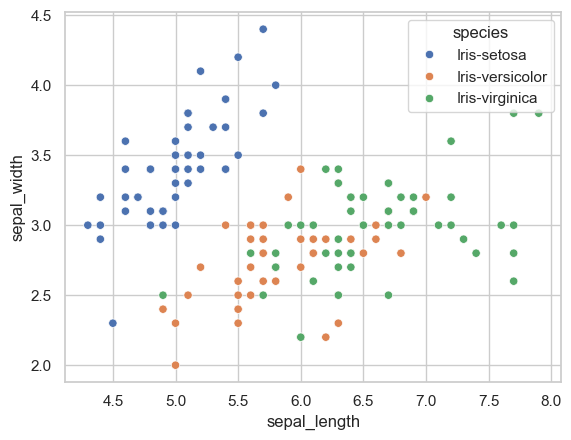

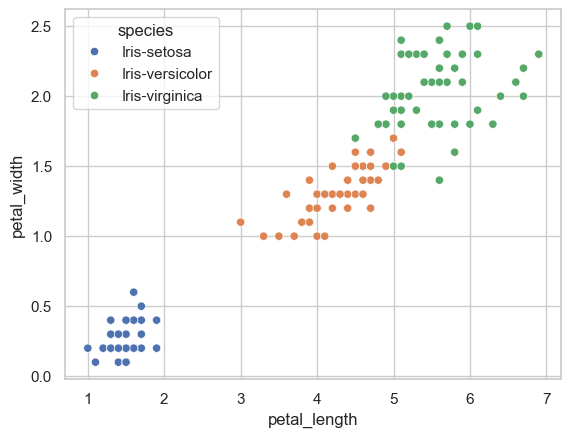

In [53]:
sns.scatterplot(x=iris["sepal_length"], y=iris["sepal_width"], hue=iris["species"])
plt.show()
sns.scatterplot(x=iris["petal_length"], y=iris["petal_width"], hue=iris["species"])
plt.show()

#### The scatter plot when using only petal information splits the data well

In [54]:
# Splitting training and testing data
X = iris.drop(columns=["species"], axis=1)
y = iris["species"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7, shuffle=True,stratify=y ,random_state=1)

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Cross Validation to determine the best k value
k_values = []
max_knn = int((iris.shape[0])/(len(iris["species"].unique())))
results = []

scaler = StandardScaler()
test_X = scaler.fit_transform(X)

for i in range(1, max_knn):
    k_values.append(i)
    test_knn = KNeighborsClassifier(n_neighbors=i)
    test_score = cross_val_score(test_knn, test_X, y, cv=5)
    results.append(np.mean(test_score))

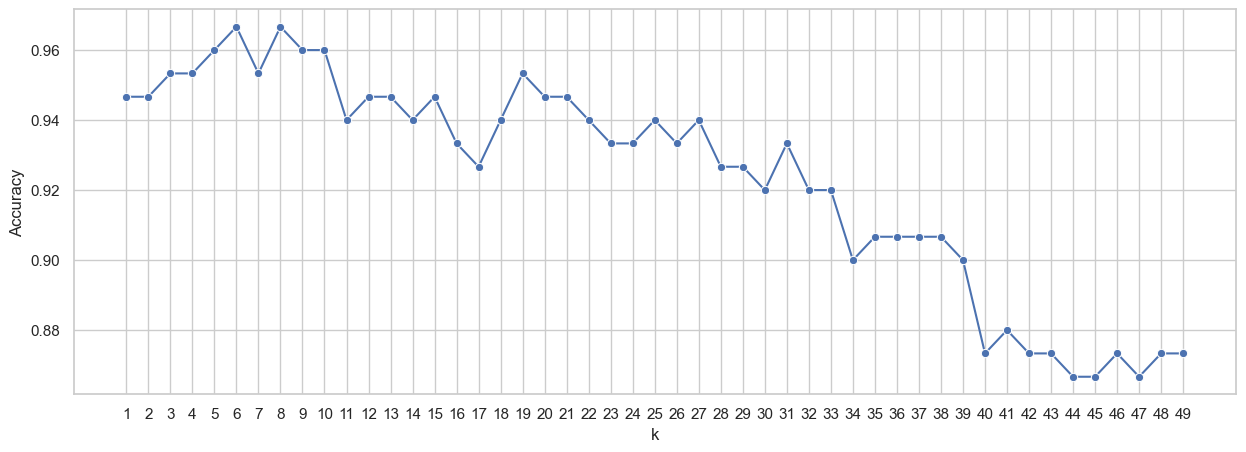

In [56]:
# Plotting the test scores against the possible k values to determine the best k value
plt.figure(figsize=(15, 5))
sns.lineplot(x = k_values, y = results, marker ="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
# Setting ticks and step size on the x-axis
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.show()

##### I choose my k value as 6

In [58]:
# Final Model
best_k = 6
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
report = classification_report(y_true=y_test, y_pred=y_pred)
print("Accuracy:", round(accuracy, ndigits=3))
print(report)

Accuracy: 0.952
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        35
Iris-versicolor       0.89      0.97      0.93        35
 Iris-virginica       0.97      0.89      0.93        35

       accuracy                           0.95       105
      macro avg       0.95      0.95      0.95       105
   weighted avg       0.95      0.95      0.95       105



##### A thing to note is that Iris Setosa is easily classified, the other two species are close to each other but still relevantly easier to classify